If you would like to investigate the CNN in different ways, use https://github.com/utkuozbulak/pytorch-cnn-visualizations as a reference.

In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# from visualization_utils import preprocess_image, convert_to_grayscale
# from guided_backprop import GuidedBackprop

ModuleNotFoundError: ignored

In [3]:
"""
Taken directly from https://github.com/utkuozbulak/pytorch-cnn-visualizations
"""

import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im





In [4]:
"""
Taken directly from https://github.com/utkuozbulak/pytorch-cnn-visualizations
"""

import torch
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        self.model.zero_grad()
        
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
    

In [17]:
BASE_DIR = '/content/drive/My Drive/Mali'
COUNTRY = 'mali_2015'
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models','mali_trained_model', 'mali_trained_model1.pt')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
model = torch.load(CNN_SAVE_DIR, map_location=torch.device('cpu'))
model = model.eval()

In [32]:
os.listdir('/content/drive/My Drive/Mali/activation_maps/images')

['bad_image.png',
 'roads.png',
 'water.png',
 '7.10115660875_39.99599417159801_7.10115660875_40.010966093.png',
 'sample.png',
 'sample2.png',
 'Galwan-Valley-map.jpg',
 'Galwan-Valley-map.png',
 'Chennai.jpg',
 'Chennai.png',
 'mali_image.jpg',
 'mali_image.png',
 'mali_image1.png']

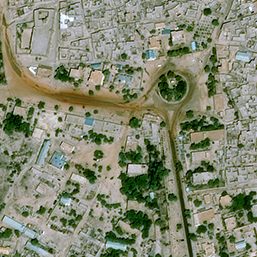

In [33]:
# choice = '7.10115660875_39.99599417159801_7.10115660875_40.010966093.png'
choice = 'mali_image1.png'
image_dir = f'/content/drive/My Drive/Mali/activation_maps/images/{choice}'
image = Image.open(image_dir).convert('RGB')
image

In [34]:
proc_image = preprocess_image(image)

# prediction by model
preds = model(proc_image)
print('prediction:', preds)
target = torch.argmax(preds).item()

prediction: tensor([[-0.0030,  1.5407, -1.9665]], grad_fn=<AddmmBackward>)


In [35]:
GBP = GuidedBackprop(model)
guided_grads = GBP.generate_gradients(proc_image, target)
grayscale_guided_grads = convert_to_grayscale(guided_grads)

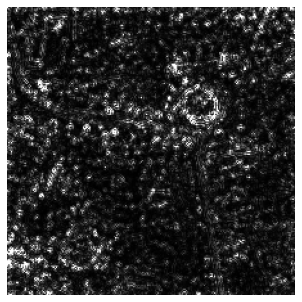

In [36]:
img = np.squeeze(grayscale_guided_grads.transpose(1, 2, 0))
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img, cmap='gray', vmin=0, vmax=1)
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)